# Sampling from Known and Unknown Measures

In [1]:
from qmcpy import *
from numpy import *
from matplotlib import pyplot

## Inverse CDF Transform

### Lattice Samples Transformed to Exponential
$y \sim exp(\lambda)$\
$\text{pdf y } f(x) = \lambda e^{-\lambda x}$\
$\text{cdf y } F(x) = 1-e^{-\lambda x}$\
$\text{inverse cdf } F^{-1}(x) = \frac{-log(1-x)}{\lambda}$\
$\therefore y \sim \frac{-log(1-u)}{\lambda} \text{ for } u \sim U_d(0,1)$

In [2]:
# constants
n_samples = 2**8
lambda_ = 1.5
exp_pdf = lambda x,l=lambda_: l*exp(-l*x)
exp_inverse_cdf = lambda u,l=lambda_: -log(1-u)/l

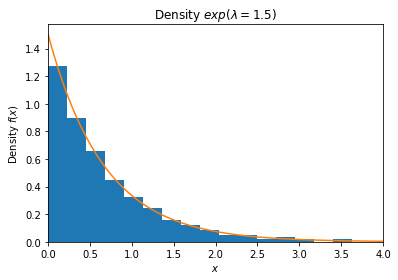

In [9]:
# 1 dimension
distribution = Lattice(dimension=1)
exponential_measure = InverseCDFTransform(distribution,inverse_cdf_fun=exp_inverse_cdf)
exp_samples = exponential_measure.gen_mimic_samples(n_min=0,n_max=n_samples)
# samples plot
pyplot.hist(exp_samples,bins='auto',density=True)
# curve plot
pts = arange(0,4,.01)
pyplot.plot(pts,exp_pdf(pts))
# plot metas
pyplot.xlim([0,4])
pyplot.xlabel('$x$')
pyplot.ylabel('Density $f(x)$')
pyplot.title('Density $exp(\lambda=%.1f)$'%lambda_);

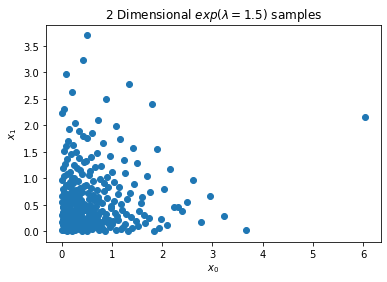

In [4]:
# 2 dimension
distribution = Sobol(dimension=2)
exponential_measure = InverseCDFTransform(distribution,inverse_cdf_fun=exp_inverse_cdf)
exp_samples = exponential_measure.gen_mimic_samples(n_min=0,n_max=n_samples)
pyplot.scatter(exp_samples[:,0],exp_samples[:,1])
pyplot.xlabel('$x_0$')
pyplot.ylabel('$x_1$')
pyplot.title('2 Dimensional $exp(\lambda=%.1f)$ samples'%lambda_);

## Cauchy Samples
$y \sim cauchy(x_0,\gamma)$\
$\text{pdf y } f(x) = [\pi \gamma (1+(\frac{x-x_0}{\gamma})^2)]^{-1}$\
$\text{cdf y } F(x) = \frac{1}{\pi} arctan(\frac{x-x_0}{\gamma}) + 1/2$\
$\text{inverse cdf } F^{-1}(x) = tan(\pi(x-\frac{1}{2}))\gamma + x_0$\
$\therefore y \sim  tan(\pi(u-\frac{1}{2}))\gamma + x_0 \text{ for } u \sim U_d(0,1)$

In [12]:
# constants
n_samples = 2**8
x0 = -2
gamma = .75
cauchy_pdf = lambda x,x0=x0,gamma=gamma: (pi*gamma*(1+((x-x0)/gamma)**2))**(-1)
cauchy_inverse_cdf = lambda u,x0=x0,gamma=gamma: tan(pi*(u-.5))*gamma+x0

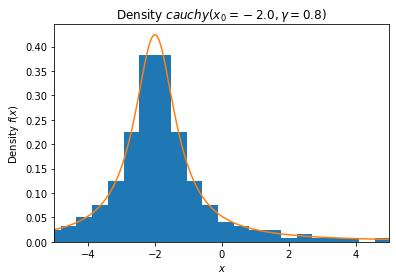

In [13]:
# 1 dimension
distribution = Sobol(dimension=1)
cauchy_measure = InverseCDFTransform(distribution,inverse_cdf_fun=cauchy_inverse_cdf)
cauchy_samples = cauchy_measure.gen_mimic_samples(n_min=0,n_max=n_samples)
# samples plot
pyplot.hist(cauchy_samples,bins='auto',density=True)
# curve plot
pts = arange(-5,5,.01)
pyplot.plot(pts,cauchy_pdf(pts))
# plot metas
pyplot.xlim([-5,5])
pyplot.xlabel('$x$')
pyplot.ylabel('Density $f(x)$')
pyplot.title('Density $cauchy(x_0=%.1f,\gamma=%.1f)$'%(x0,gamma));